# Setup

In [1]:
from typing import Literal

from seaborn import set_theme
set_theme(font_scale=0.75)

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchvision import models

from src.utils import Config

# seed for reproducibility
torch.manual_seed(Config.SEED)

torch.__version__

'2.6.0'

# Execution

In [2]:
from src.trainer import get_trainer
from src.utils import DataPreprocessor
from src.utils import ViTLoss, Scheduler

## Data preprocessing

In [3]:
dp = DataPreprocessor(Config.DATA_PATH,
                      transform=Config.transform,
                      resize_shape=Config.INPUT_SHAPE,)
train, val, test = dp.preprocess(test_ratio=Config.TEST_RATIO,
                                 val_ratio=Config.VAL_RATIO,
                                 batch_size=Config.BATCH_SIZE,
                                 seed=Config.SEED)
# dp.clear_cache()
# Print class names and sizes
classes = dp.classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Train size: {len(train.dataset)}")
print(f"Validation size: {len(val.dataset)}")
print(f"Test size: {len(test.dataset)}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train size: 1816
Validation size: 321
Test size: 378


In [4]:
# dp.clear_cache() # clear cache to free up memory. Attention: this will delete all cached datasets files

## Training

In [5]:
# Train the model
model_type = 'vit' # 'cnn' or 'tl' or 'vit' 8,534,308
trainer = get_trainer(model_type, classes)
# summary(trainer.model, input_size=(Config.BATCH_SIZE, Config.NB_CHANNELS, *Config.INPUT_SHAPE),
#         col_names = ('input_size', 'output_size', 'num_params'), verbose = 0) # from torchinfo

In [ ]:
Config.LR *= 5e-2
train_criterion = ViTLoss(label_smoothing=Config.LABEL_SMOOTHING) \
    if model_type == 'vit' else nn.CrossEntropyLoss()
val_criterion = ViTLoss(label_smoothing=0.0) \
    if model_type == 'vitt' else nn.CrossEntropyLoss()
optimizer = optim.AdamW(trainer.model.parameters(), lr=Config.LR, betas=Config.BETAS, eps=Config.EPS) \
    if model_type == 'vit' else optim.Adam(trainer.model.parameters(), lr=Config.LR)
# Optimizer with different learning rates
scheduler = Scheduler(optimizer, Config.D_MODEL, Config.WARMUP_STEPS)\
    if model_type == 'vitt' else optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=Config.PATIENCE//4, min_lr=1e-5)
    # if model_type == 'vitt' else None #optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=Config.STEP_AFTER, min_lr=1e-5)

train_losses, val_losses = trainer.train(train,
                                        val,
                                        train_criterion,
                                        val_criterion,
                                        optimizer,
                                        scheduler = scheduler,
                                        epochs = Config.EPOCHS, 
                                        patience = Config.PATIENCE,
                                        print_every = Config.PRINT_EVERY,
                                        step_per = Config.STEP_PER[model_type],
                                        step_after = Config.STEP_AFTER,
                                        save = Config.SAVE_MODEL)

Training SignLanguageViT model using: epochs=100 -- patience=20 -- print_every=5 -- step_per=epoch -- step_after=5
Epoch [  1/100] Loss: 3.48443 | Val loss: 2.22214 | LR: 0.000050 -- Best model saved
Epoch [  5/100] Loss: 0.66636 | Val loss: 0.47038 | LR: 0.000050 -- Best model saved
Epoch [ 10/100] Loss: 0.19211 | Val loss: 0.31695 | LR: 0.000050 -- Best model saved
Epoch [ 15/100] Loss: 0.08600 | Val loss: 0.26430 | LR: 0.000050 -- Best val loss: 0.23302 | Patience: 4/20
Epoch [ 20/100] Loss: 0.02407 | Val loss: 0.20297 | LR: 0.000050 -- Best val loss: 0.15863 | Patience: 3/20
Epoch [ 25/100] Loss: 0.01735 | Val loss: 0.27466 | LR: 0.000045 -- Best val loss: 0.15863 | Patience: 8/20
Epoch [ 30/100] Loss: 0.00947 | Val loss: 0.29124 | LR: 0.000041 -- Best val loss: 0.15863 | Patience: 13/20
Epoch [ 35/100] Loss: 0.00360 | Val loss: 0.27313 | LR: 0.000036 -- Best val loss: 0.15863 | Patience: 18/20
Early stopping after epoch 37
Number of epochs: 36 | Total duration: 0:16:38


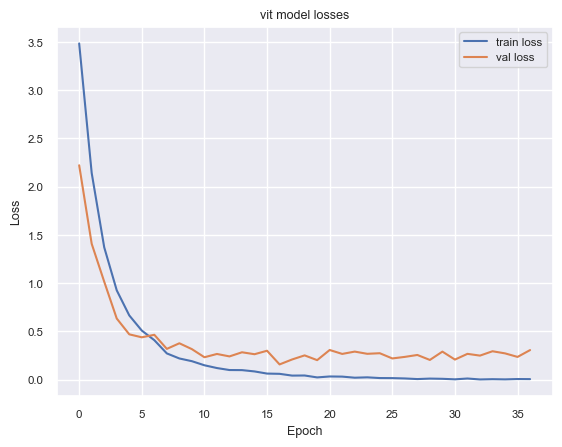

In [7]:
# Plot the training and validation losses
trainer.plot_losses(train_losses, val_losses, model_type)

## Testing

### CNN Model

In [8]:
# Evaluate
model_type = 'cnn' # 'cnn' or 'tl' or 'vt' 98.14814814814815

trainer = get_trainer(model_type, classes)
trainer.load_model(Config.MODEL_SAVE_PATH[model_type])
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

98.41269841269842

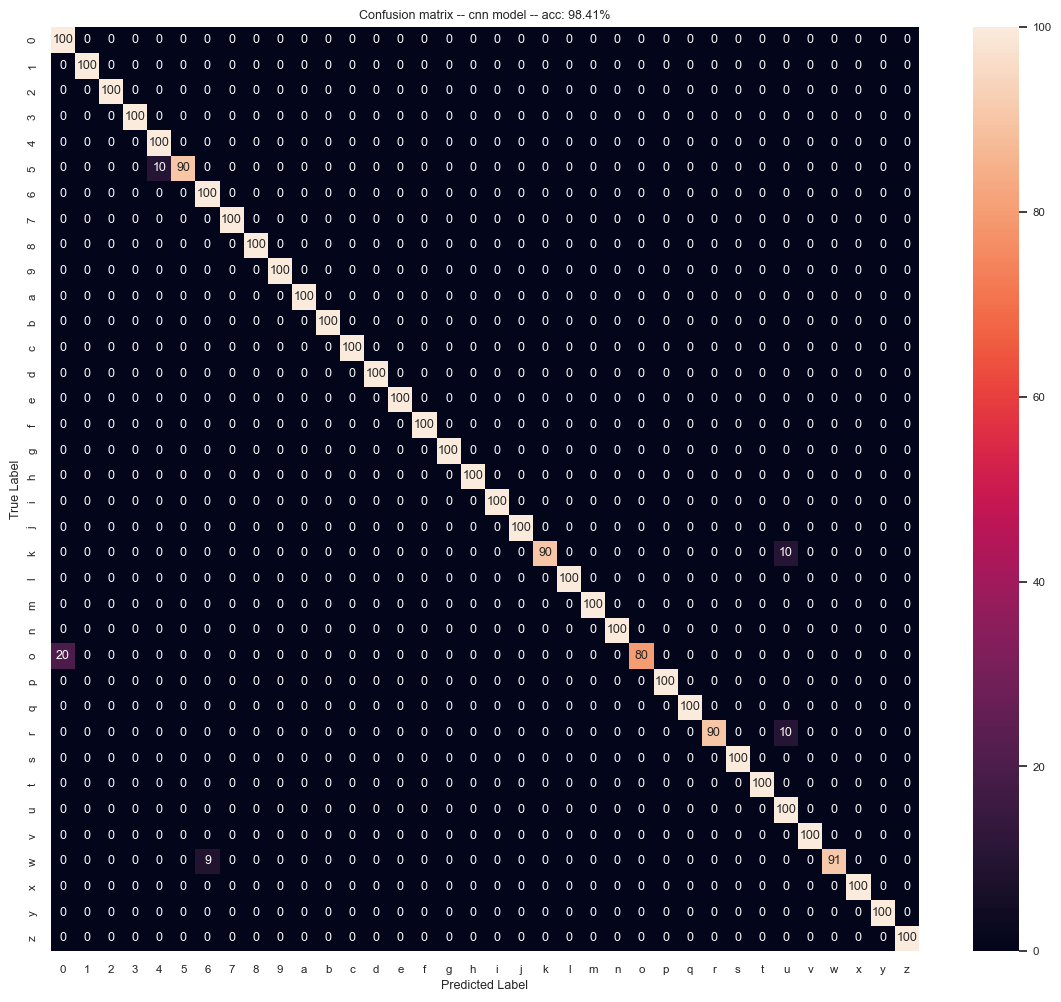

In [9]:
trainer.plot_confusion_matrix(y_true, y_pred, classes,
                                figsize=Config.FIG_SIZE, normalize=True, fmt='.0f',
                                model_type=model_type,accuracy=acc)

### Transfert Learning model

In [10]:
model_type = 'tl' # 'cnn' or 'tl' or 'vt' 75.66137566137566

trainer = get_trainer(model_type, classes)
trainer.load_model(Config.MODEL_SAVE_PATH[model_type])
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

90.74074074074075

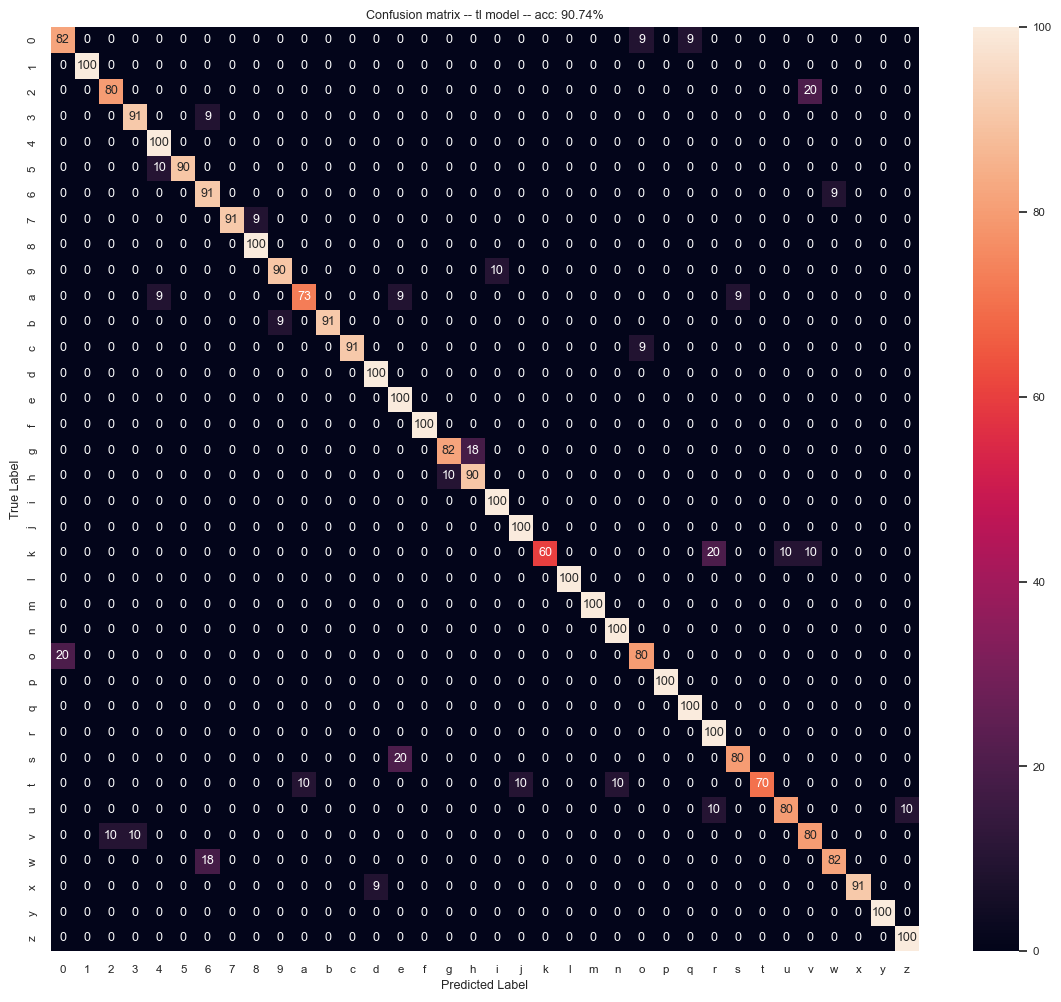

In [11]:
trainer.plot_confusion_matrix(y_true, y_pred, classes,
                                figsize=Config.FIG_SIZE, normalize=True, fmt='.0f',
                                model_type=model_type,accuracy=acc)

### Vision Transformer model

In [12]:
model_type = 'vit' # 'cnn' or 'tl' or 'vit' #93.3862433862434 for 1500 warmup steps

trainer = get_trainer(model_type, classes)
trainer.load_model(Config.MODEL_SAVE_PATH[model_type])
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

94.97354497354497

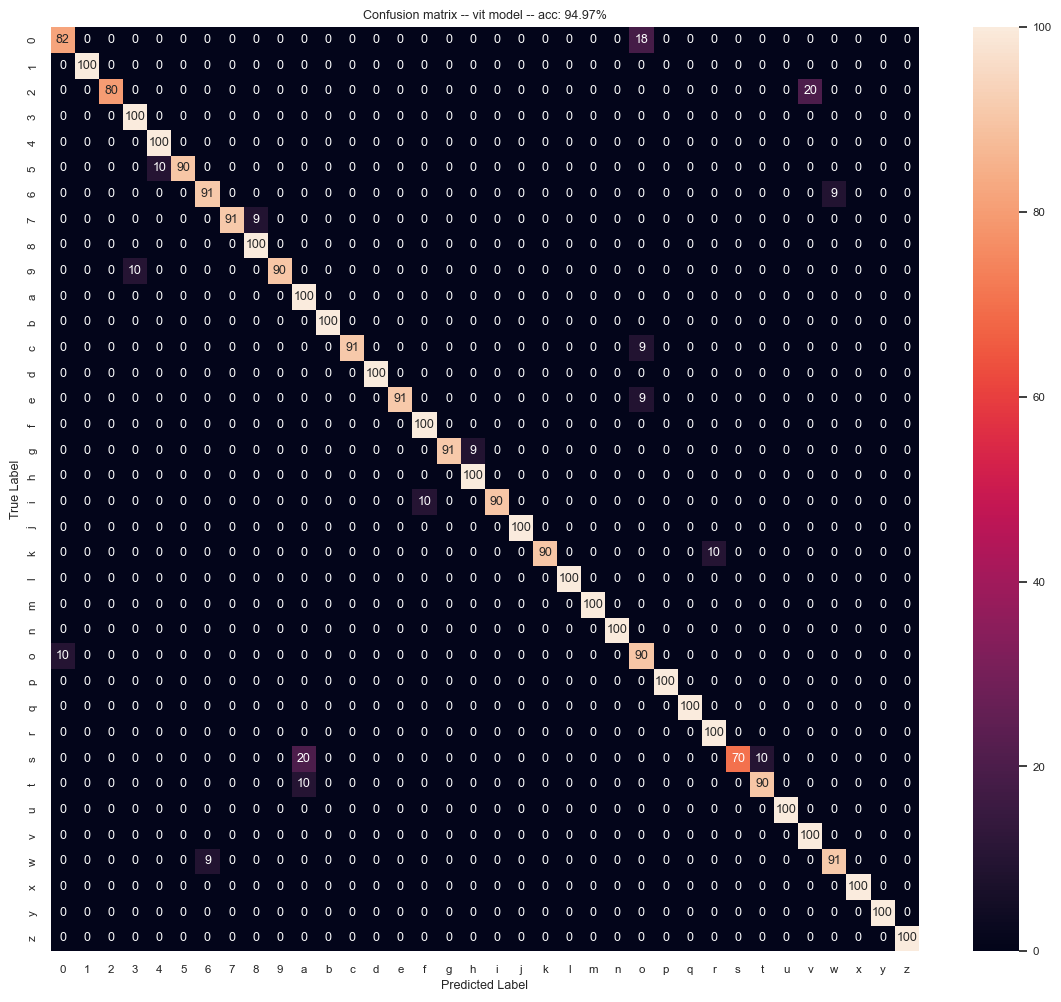

In [13]:
trainer.plot_confusion_matrix(y_true, y_pred, classes,
                                figsize=Config.FIG_SIZE, normalize=True, fmt='.0f',
                                model_type=model_type,accuracy=acc)